In [1]:
import sys
import importlib
# Make imports work
sys.path.insert(0, '../')

In [75]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from colour import Color
from mhealth_anomaly_detection import anomaly_detection
from mhealth_anomaly_detection import format_axis as fa
from mhealth_anomaly_detection import load_refs as lr
from mhealth_anomaly_detection import plots

In [26]:
YEAR = 2
EXPERIMENT = 'exp06'
exp06_ad = pd.read_csv(
    Path('../cache', f'GLOBEM-{YEAR}_{EXPERIMENT}_intermediate.csv')    
)
exp06 = pd.read_csv(
    Path('../cache', f'GLOBEM-{YEAR}_{EXPERIMENT}.csv')    
)
exp06_ad

/var/folders/yl/t10bslz11cgdwwfk10mvyr1h0000gn/T/ipykernel_27799/95810818.py:3: DtypeWarning: Columns (366,367,368,369,370,371,372,373,374,375) have mixed types. Specify dtype option on import or set low_memory=False.
  exp06_ad = pd.read_csv(


,subject_id,study_day,window_size,platform,date,f_loc:phone_locations_locmap_percent_in_locmap_greens:allday,f_loc:phone_locations_locmap_duration_in_locmap_greens:allday,f_loc:phone_locations_locmap_percent_in_locmap_exercise:allday,f_loc:phone_locations_locmap_duration_in_locmap_exercise:allday,f_loc:phone_locations_locmap_percent_in_locmap_study:allday,...,RollingMean_anomaly,PCA_003_anomaly,NMF_003_anomaly,SVM_poly_anomaly,PCA_005_anomaly,NMF_005_anomaly,SVM_rbf_anomaly,SVM_sigmoid_anomaly,PCA_010_anomaly,NMF_010_anomaly
0,INS-W_300,0,7,ios,2019-03-21,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
1,INS-W_300,1,7,ios,2019-03-22,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
2,INS-W_300,2,7,ios,2019-03-23,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
3,INS-W_300,3,7,ios,2019-03-24,0.000000,0.000000,0.000000,0.000000,0.000000,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
4,INS-W_300,4,7,ios,2019-03-25,1.299894,18.718083,6.537361,94.136033,6.067866,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167611,INS-W_572,92,28,ios,2019-06-21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
167612,INS-W_572,93,28,ios,2019-06-22,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
167613,INS-W_572,94,28,ios,2019-06-23,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
167614,INS-W_572,95,28,ios,2019-06-24,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False


Index(['subject_id', 'start', 'stop', 'days', 'complete_days', 'phq_start',
       'phq_stop', 'phq_change', 'RollingMean_anomaly', 'PCA_003_anomaly',
       'NMF_003_anomaly', 'SVM_poly_anomaly', 'PCA_005_anomaly',
       'NMF_005_anomaly', 'SVM_rbf_anomaly', 'SVM_sigmoid_anomaly',
       'PCA_010_anomaly', 'NMF_010_anomaly', 'period', 'window_size'],
      dtype='object')

In [9]:
anomaly_detector_cols = [
    d for d in exp06_ad.columns if d.endswith("_anomaly")
]
palette = lr.get_colors('../lib/colors.json')

In [15]:
exp06_ad.study_day.max()

96

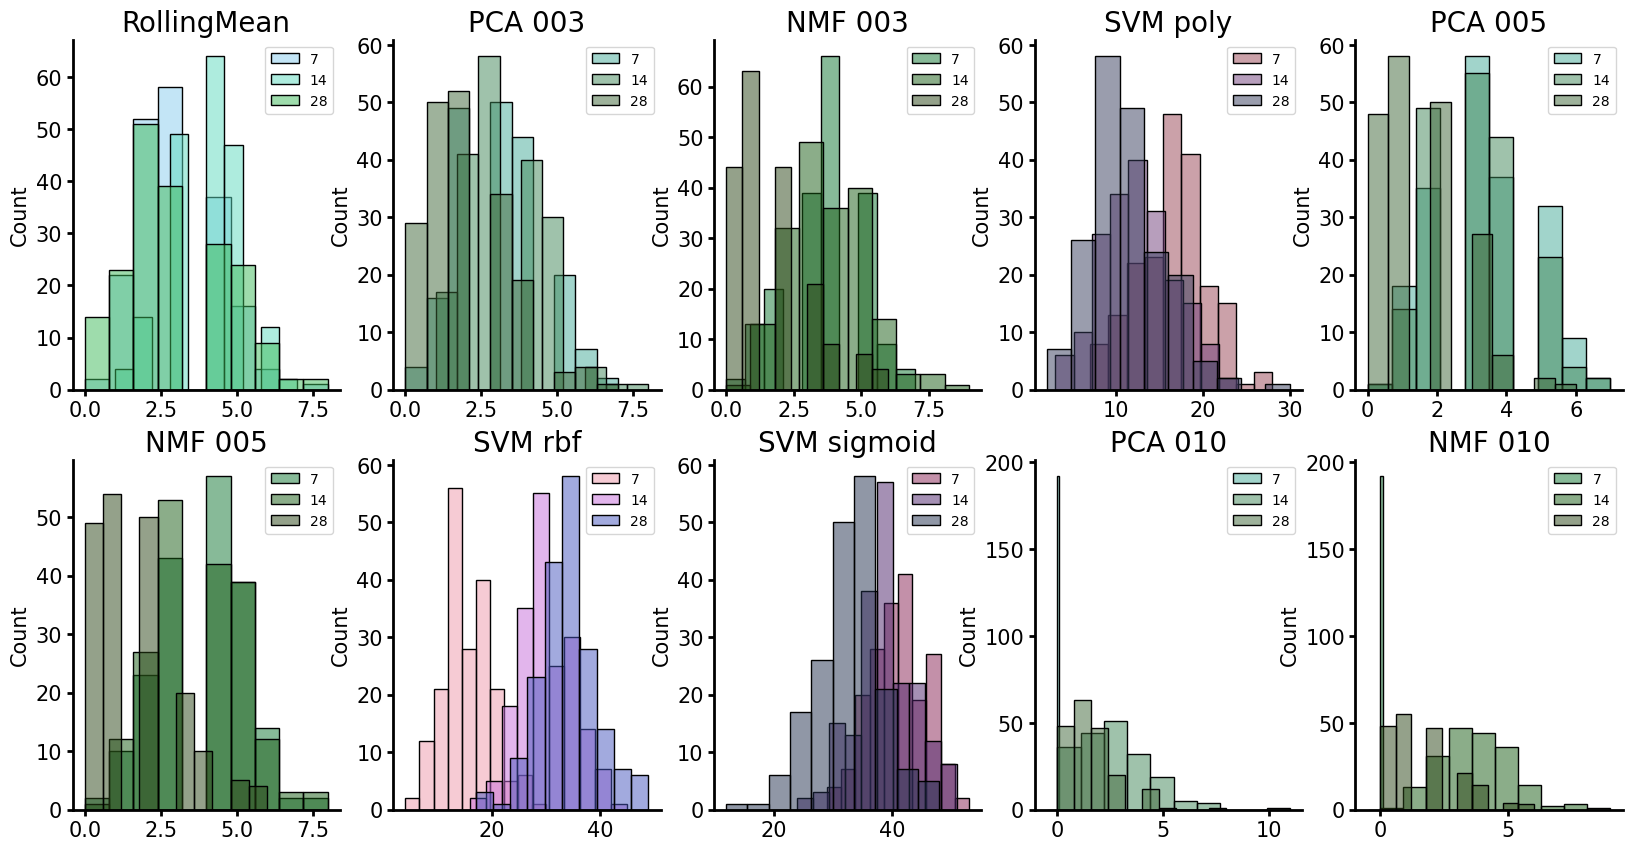

In [25]:
anoms = exp06_ad.groupby(['subject_id', 'window_size'])[anomaly_detector_cols].sum().reset_index()
fig, axes = plt.subplots(figsize=(20,10), nrows=2, ncols=5)
gray = Color("black")

for i, ad in enumerate(anomaly_detector_cols):
    ax = axes.flatten()[i]
    dname = ad.split('_anomaly')[0]
    base_c = Color(palette['model'][dname])
    p = list(base_c.range_to(gray, 7))
    for i, (ws, w_df) in enumerate(anoms.groupby('window_size')):
        sns.histplot(
            w_df[ad],
            color=p[i].hex_l,
            ax=ax,
            bins=10,
            alpha=.5,
            label=ws
        )
    ax.set_title(dname.replace('_', ' '), fontsize=20)
    ax.legend()
    ax.set_xlabel('')
    fa.despine_thicken_axes(ax, fontsize=15)


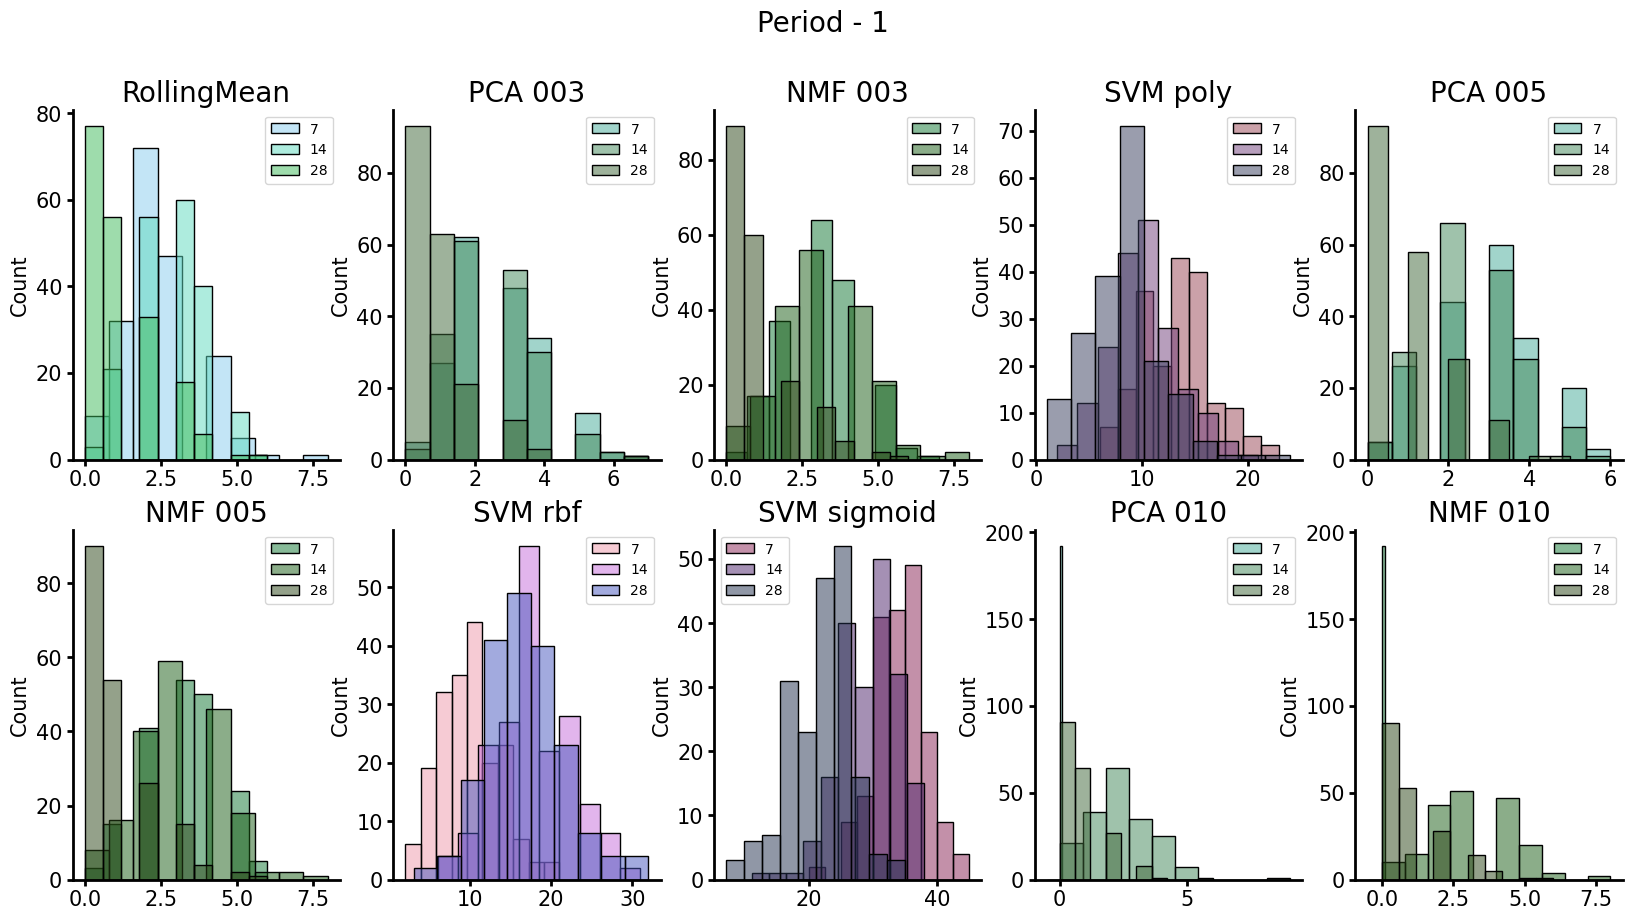

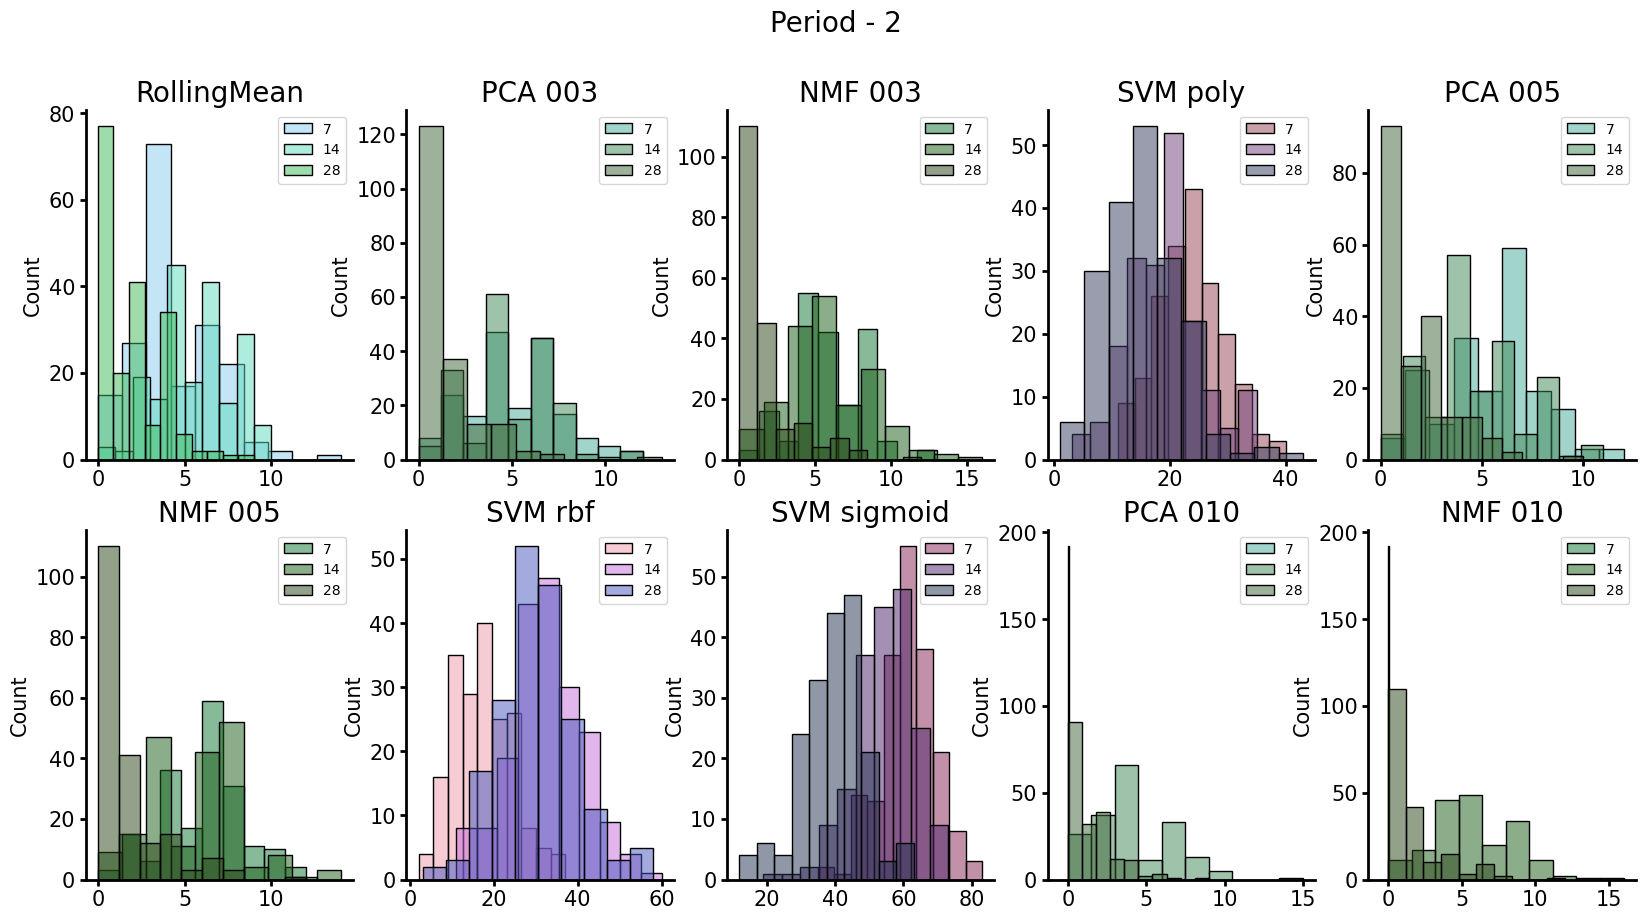

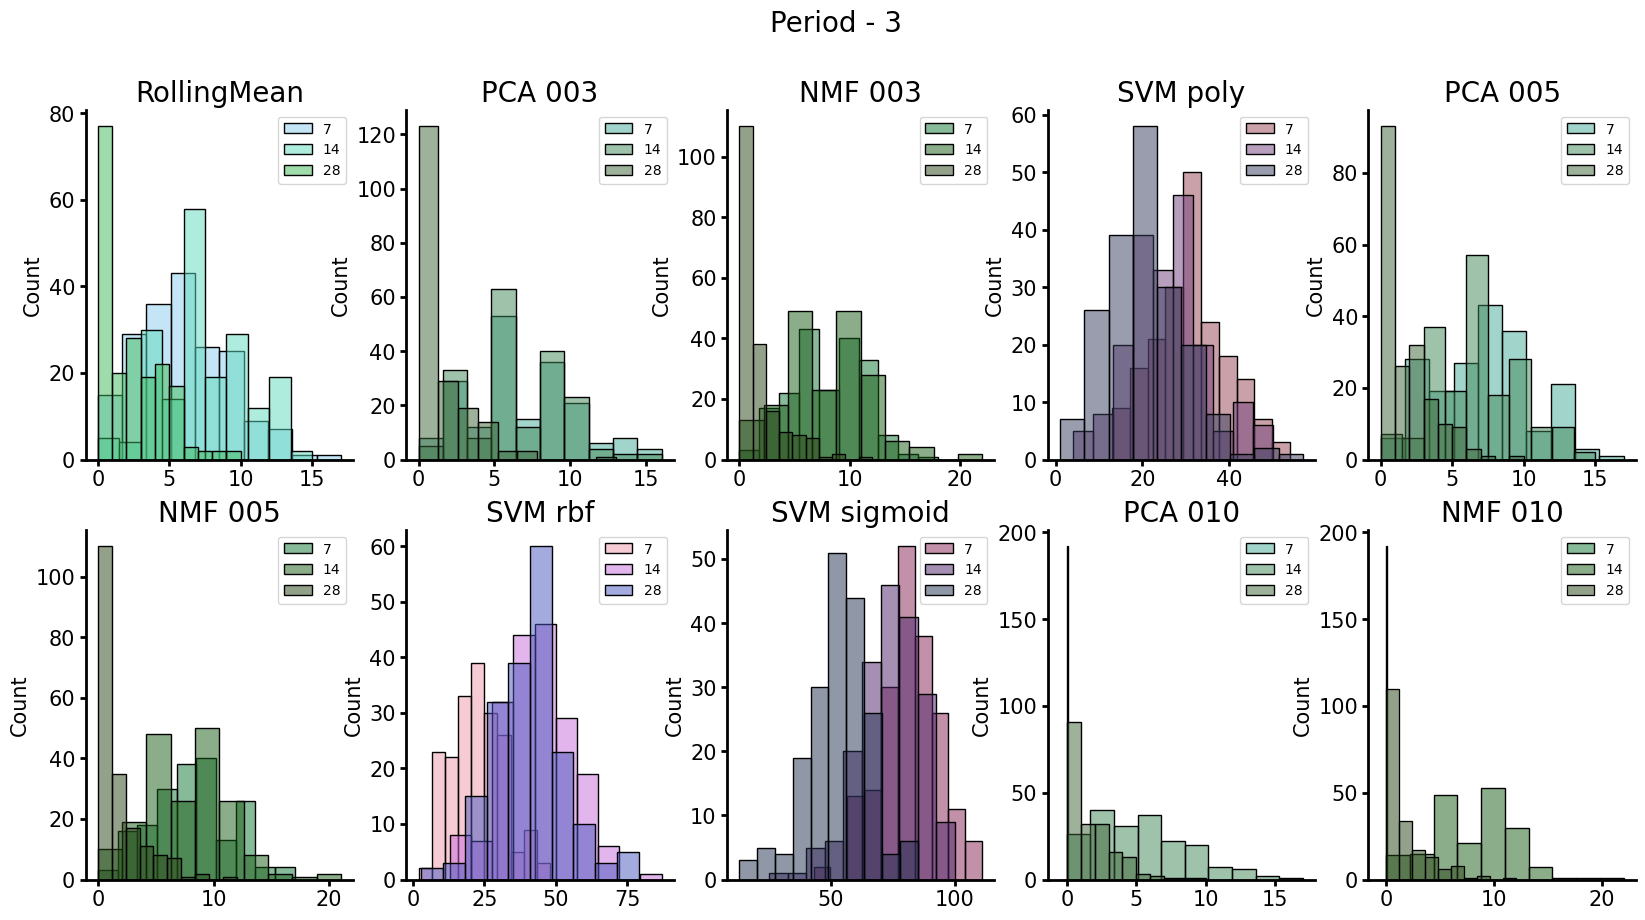

In [33]:
anoms_period = exp06.groupby(['subject_id', 'window_size', 'period'])[anomaly_detector_cols].sum().reset_index()
gray = Color("black")

for n, n_df in anoms_period.groupby('period'):
    fig, axes = plt.subplots(figsize=(20,10), nrows=2, ncols=5)
    plt.suptitle(f'Period - {n}', fontsize=20)
    for i, ad in enumerate(anomaly_detector_cols):
        ax = axes.flatten()[i]
        dname = ad.split('_anomaly')[0]
        base_c = Color(palette['model'][dname])
        p = list(base_c.range_to(gray, 7))
        for i, (ws, w_df) in enumerate(n_df.groupby('window_size')):
            sns.histplot(
                w_df[ad],
                color=p[i].hex_l,
                ax=ax,
                bins=10,
                alpha=.5,
                label=ws
            )
        ax.set_title(dname.replace('_', ' '), fontsize=20)
        ax.legend()
        ax.set_xlabel('')
        fa.despine_thicken_axes(ax, fontsize=15)


In [85]:
importlib.reload(anomaly_detection)
target = 'phq_'
phq_anomalies_qc = exp06[
    (exp06.days >= exp06.period*6) & 
    (exp06.days <= exp06.period*8)
]
info_cols = [
    'subject_id',
    'period',
    'window_size',
]
corr = anomaly_detection.correlateDetectedToOutcome(
    phq_anomalies_qc,
    anomaly_detector_cols,
    outcome_col=target,
    groupby_cols=info_cols,
)
corr

,detector,rho,p,n,subject_id,period,window_size
0,RollingMean_anomaly,-0.645746,0.060296,9,INS-W_300,1,7
1,PCA_003_anomaly,0.427121,0.251539,9,INS-W_300,1,7
2,NMF_003_anomaly,0.038352,0.921966,9,INS-W_300,1,7
3,SVM_poly_anomaly,-0.423423,0.256114,9,INS-W_300,1,7
4,PCA_005_anomaly,0.376685,0.317666,9,INS-W_300,1,7
...,...,...,...,...,...,...,...
17275,NMF_005_anomaly,0.211830,0.648400,7,INS-W_572,3,28
17276,SVM_rbf_anomaly,-0.336581,0.460411,7,INS-W_572,3,28
17277,SVM_sigmoid_anomaly,-0.037743,0.935972,7,INS-W_572,3,28
17278,PCA_010_anomaly,0.600925,0.153574,7,INS-W_572,3,28


<AxesSubplot: xlabel='rho', ylabel='subject_id'>

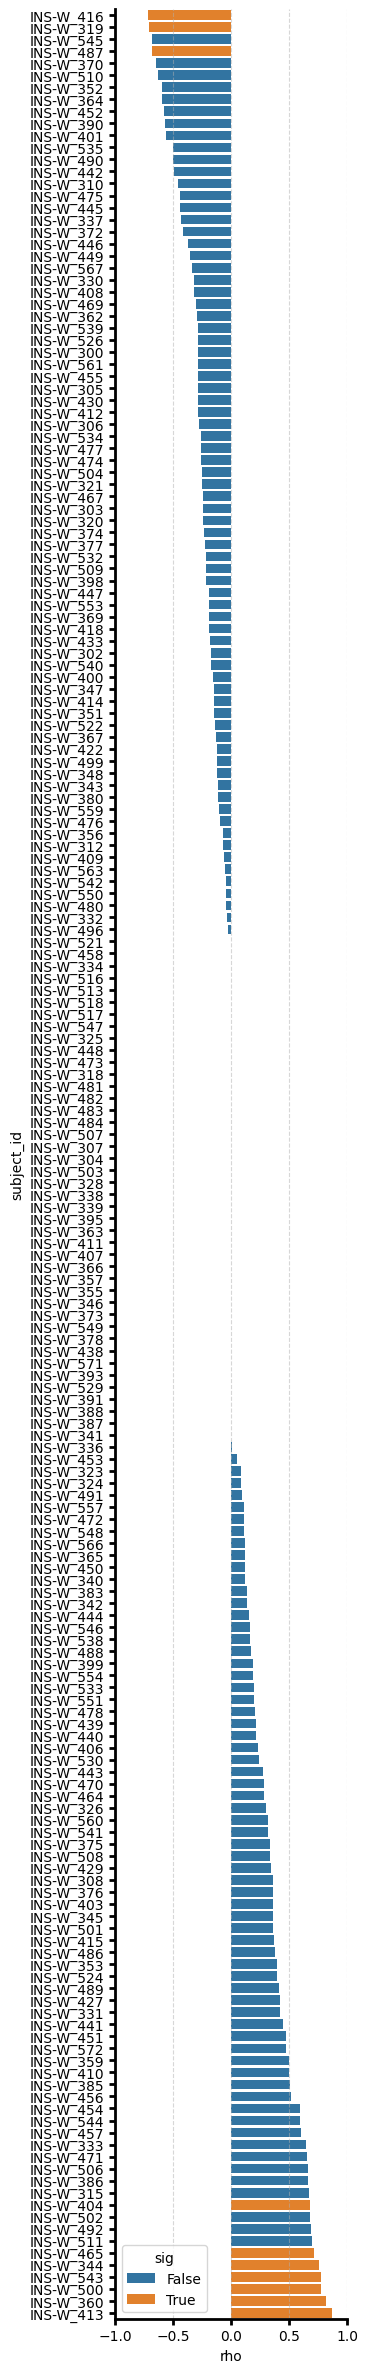

In [95]:
fig, ax = plt.subplots(figsize=(3,30))
subset = corr[
    (corr.period == 1) &
    (corr.window_size == 14) & 
    (corr.detector == 'PCA_010_anomaly')
].sort_values(by='rho')
subset['log10p'] = np.log10(subset['p'])
subset['sig'] = subset['p'] < 0.05
sns.barplot(
    x='rho',
    y='subject_id',
    hue='sig',
    data=subset,
    dodge=False,
    ax=ax,
)
ax.set_xlim(-1, 1)
ax.grid(axis='x', alpha=.5, ls='dashed')
fa.despine_thicken_axes(ax, fontsize=10)


/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


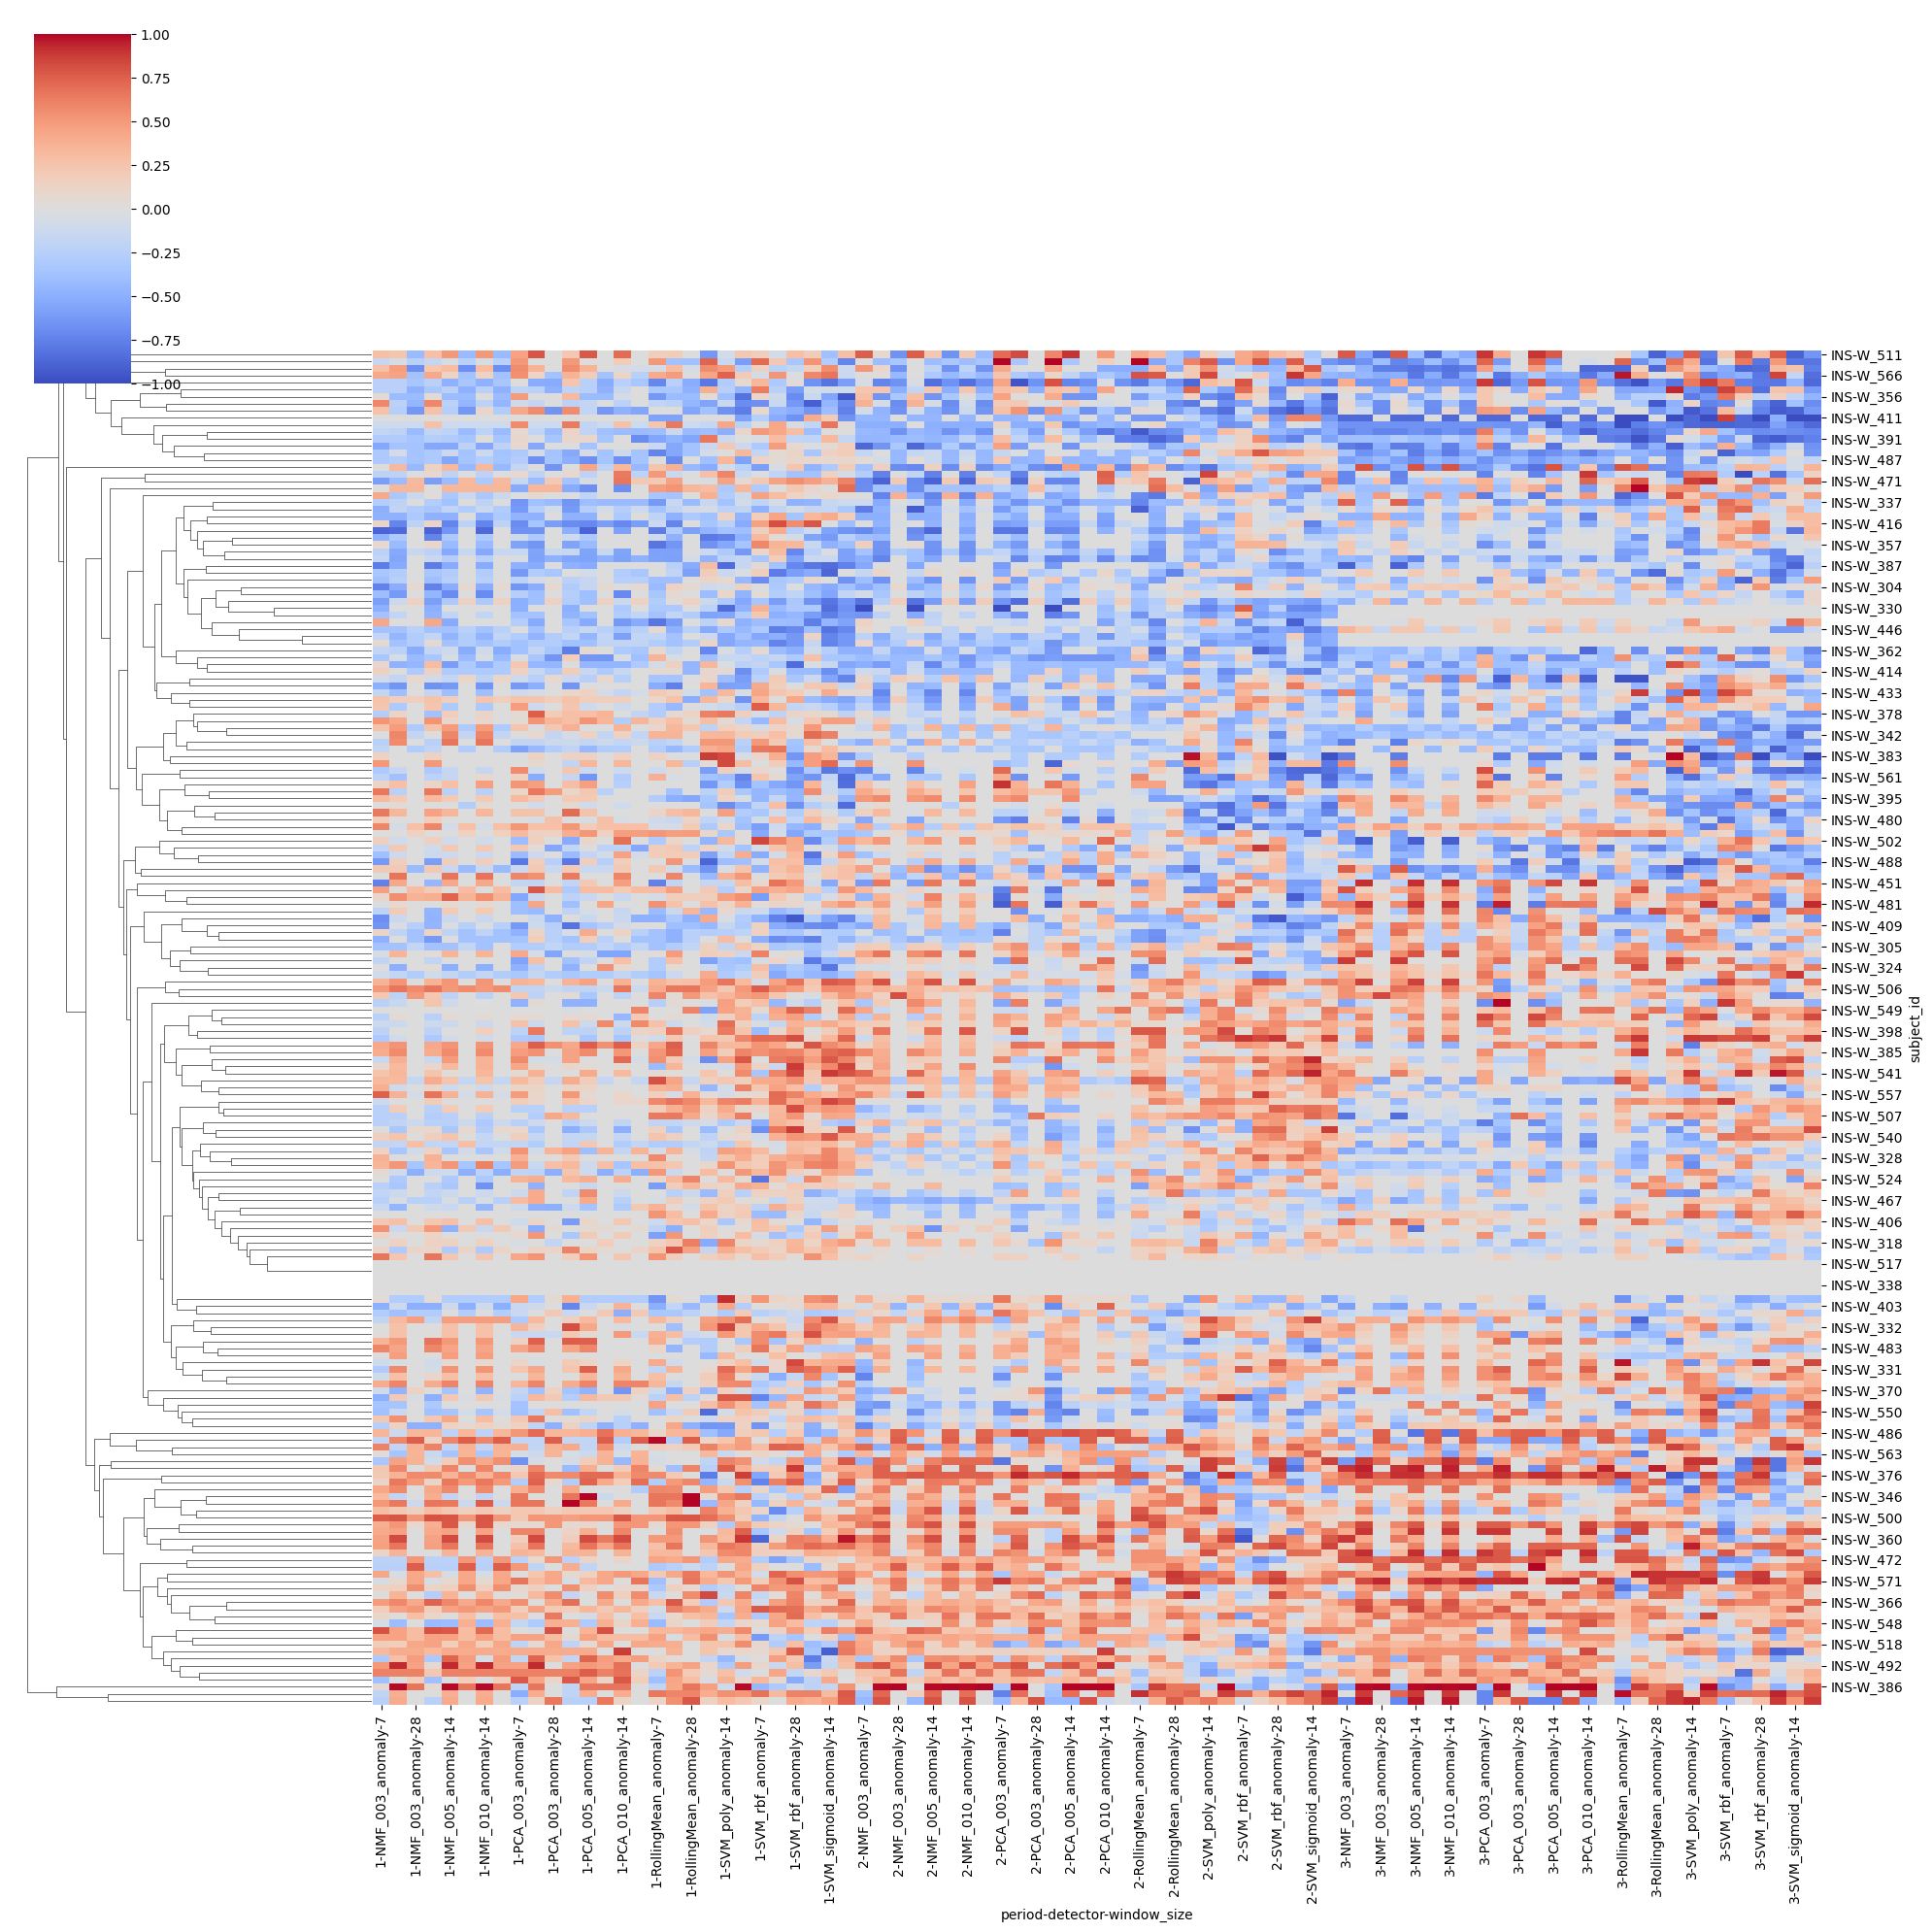

In [96]:
vals = corr.pivot_table(
    index='subject_id',
    columns=['period', 'detector', 'window_size'],
    values='rho',
)

anot = corr.pivot_table(
    index='subject_id',
    columns=['period', 'detector', 'window_size'],
    values='p',
)

anot = (anot < 0.05)

sns.clustermap(
    vals,
    #annot=anot,
    cmap='coolwarm',
    col_cluster=False,
    vmin=-1,
    vmax=1,
    figsize=(20,20)
)

In [88]:
corr.period.nunique()

3

In [89]:
sig_corr = corr[corr.p < 0.05]
sig_corr.sort_values(by='rho')

,detector,rho,p,n,subject_id,period,window_size
2146,SVM_rbf_anomaly,-1.0,0.0,5,INS-W_333,3,14
1831,PCA_003_anomaly,-1.0,0.0,5,INS-W_330,2,7
1832,NMF_003_anomaly,-1.0,0.0,5,INS-W_330,2,7
1834,PCA_005_anomaly,-1.0,0.0,5,INS-W_330,2,7
1835,NMF_005_anomaly,-1.0,0.0,5,INS-W_330,2,7
...,...,...,...,...,...,...,...
5814,PCA_005_anomaly,1.0,0.0,8,INS-W_386,2,28
5812,NMF_003_anomaly,1.0,0.0,8,INS-W_386,2,28
5808,PCA_010_anomaly,1.0,0.0,8,INS-W_386,2,14
5801,PCA_003_anomaly,1.0,0.0,8,INS-W_386,2,14


/var/folders/yl/t10bslz11cgdwwfk10mvyr1h0000gn/T/ipykernel_27799/2367308564.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_data[AD_col] = subject_data[AD_col].fillna(False)
/Users/akre96/Code/dgc/mhealth_anomaly_detection/notebooks/../mhealth_anomaly_detection/plots.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f] = pd.to_numeric(data[f], errors='coerce')
/Users/akre96/Code/dgc/mhealth_anomaly_detection/notebooks/../mhealth_anomaly_detection/plots.py:48: SettingWithCopyWarning: 
A 

(<Figure size 1000x2125 with 17 Axes>,
 array([<AxesSubplot: title={'center': 'phq4'}, xlabel='study_day'>,
        <AxesSubplot: title={'center': 'f_loc:phone_locations_doryab_locationentropy:allday'}, xlabel='study_day'>,
        <AxesSubplot: title={'center': 'f_loc:phone_locations_barnett_circdnrtn:allday'}, xlabel='study_day'>,
        <AxesSubplot: title={'center': 'f_steps:fitbit_steps_intraday_rapids_sumsteps:allday'}, xlabel='study_day'>,
        <AxesSubplot: title={'center': 'f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout:allday'}, xlabel='study_day'>,
        <AxesSubplot: title={'center': 'f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:allday'}, xlabel='study_day'>,
        <AxesSubplot: title={'center': 'f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:allday'}, xlabel='study_day'>,
        <AxesSubplot: title={'center': 'f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:allday'}, xlabel='study_day'>,
        <AxesSubplot: tit

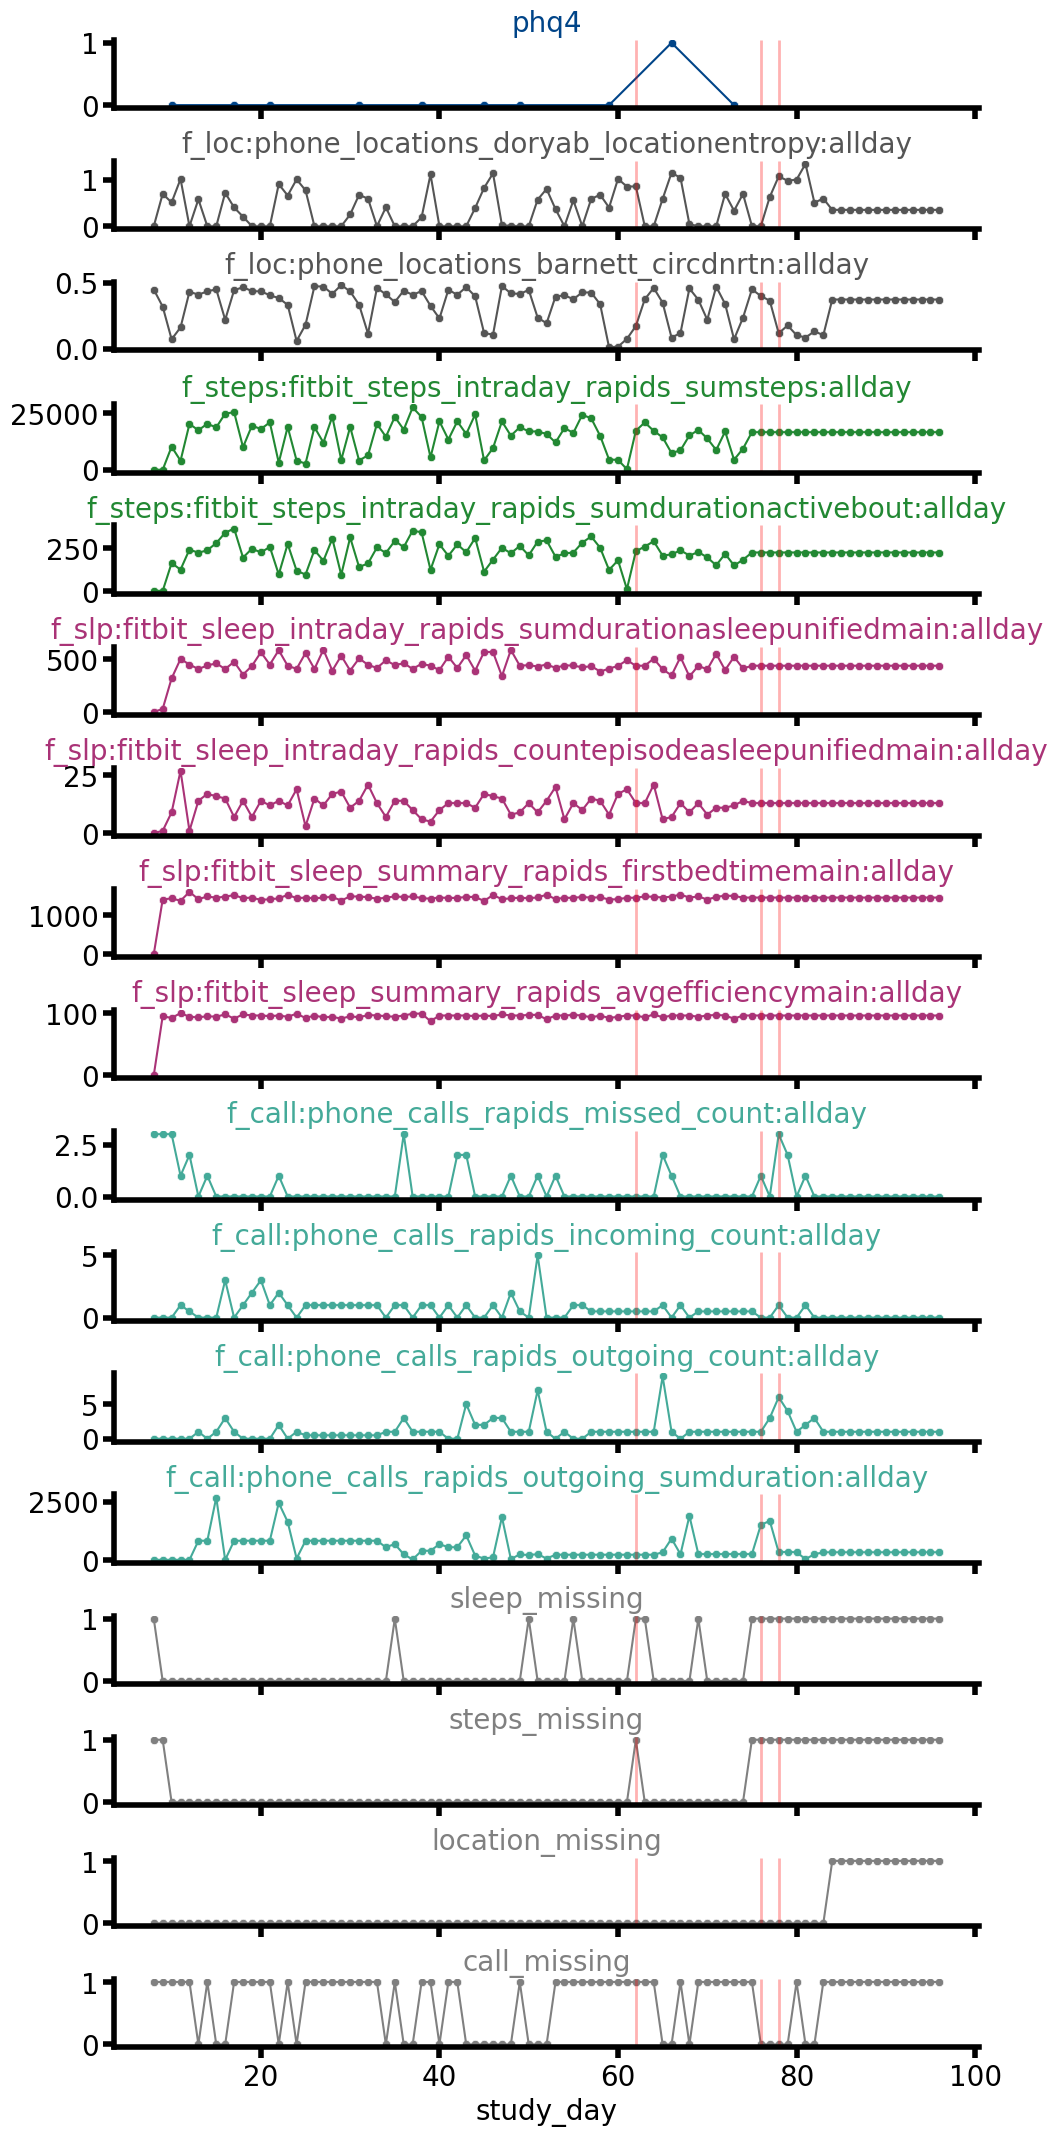

In [100]:
sid = 'INS-W_489'
AD_col = 'RollingMean_anomaly'
window_size = 28
features = [
    'f_loc:phone_locations_doryab_locationentropy:allday',
    'f_loc:phone_locations_barnett_circdnrtn:allday',
    'f_steps:fitbit_steps_intraday_rapids_sumsteps:allday',
    'f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout:allday',
    'f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:allday',
    'f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:allday',
    'f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:allday',
    'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:allday',
    'f_call:phone_calls_rapids_missed_count:allday',
    'f_call:phone_calls_rapids_incoming_count:allday',
    'f_call:phone_calls_rapids_outgoing_count:allday',
    'f_call:phone_calls_rapids_outgoing_sumduration:allday',
    'sleep_missing',
    'steps_missing',
    'location_missing',
    'call_missing',
]
palette = lr.get_colors('../lib/colors.json')
subject_data = exp06_ad[
    (exp06_ad.subject_id == sid) &
    (exp06_ad.window_size == window_size)
]
subject_data[AD_col] = subject_data[AD_col].fillna(False)
plots.lineplot_features(
    subject_data,
    plot_features=['phq4'] + features,
    anomaly_col=AD_col,
    scatter=True,
    palette=palette
)

In [92]:
exp06[
    (exp06.subject_id == sid) &
    (exp06.window_size == 28)
]

,subject_id,start,stop,days,complete_days,phq_start,phq_stop,phq_change,RollingMean_anomaly,PCA_003_anomaly,NMF_003_anomaly,SVM_poly_anomaly,PCA_005_anomaly,NMF_005_anomaly,SVM_rbf_anomaly,SVM_sigmoid_anomaly,PCA_010_anomaly,NMF_010_anomaly,period,window_size
3487,INS-W_330,10,17,7,21,0.0,2.0,2.0,0,0,0,0,0,0,0,0,0.0,0.0,1,28
3488,INS-W_330,17,21,7,12,2.0,2.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,1,28
3489,INS-W_330,21,31,7,30,2.0,0.0,-2.0,0,0,0,0,0,0,0,0,0.0,0.0,1,28
3490,INS-W_330,31,38,7,21,0.0,0.0,0.0,0,0,0,2,0,0,0,3,0.0,0.0,1,28
3491,INS-W_330,38,45,7,21,0.0,0.0,0.0,0,0,0,4,0,0,0,6,0.0,0.0,1,28
3492,INS-W_330,45,49,7,12,0.0,0.0,0.0,0,0,0,0,0,0,3,1,0.0,0.0,1,28
8051,INS-W_330,10,21,14,33,0.0,2.0,2.0,0,0,0,0,0,0,0,0,0.0,0.0,2,28
8052,INS-W_330,17,31,14,42,2.0,0.0,-2.0,0,0,0,0,0,0,0,0,0.0,0.0,2,28
8053,INS-W_330,21,38,14,51,2.0,0.0,-2.0,0,0,0,2,0,0,0,3,0.0,0.0,2,28
8054,INS-W_330,31,45,14,42,0.0,0.0,0.0,0,0,0,6,0,0,0,9,0.0,0.0,2,28
